Training samples: (10000, 32, 32, 3) Testing samples: (2000, 32, 32, 3)
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 175s 539ms/step - accuracy: 0.7240 - loss: 0.5501 - val_accuracy: 0.8010 - val_loss: 0.4092
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 197s 522ms/step - accuracy: 0.7854 - loss: 0.4473 - val_accuracy: 0.8095 - val_loss: 0.3957
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 164s 525ms/step - accuracy: 0.7946 - loss: 0.4328 - val_accuracy: 0.8185 - val_loss: 0.3881
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 183s 586ms/step - accuracy: 0.8027 - loss: 0.4222 - val_accuracy: 0.8200 - val_loss: 0.3796
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 188s 542ms/step - accuracy: 0.8038 - loss: 0.4128 - val_accuracy: 0.8140 - val_loss: 0.3896


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,750,277 (10.49 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 328,196 (1.25 MB)

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 387ms/step - accuracy: 0.8227 - loss: 0.3847
Test Accuracy: 81.40%


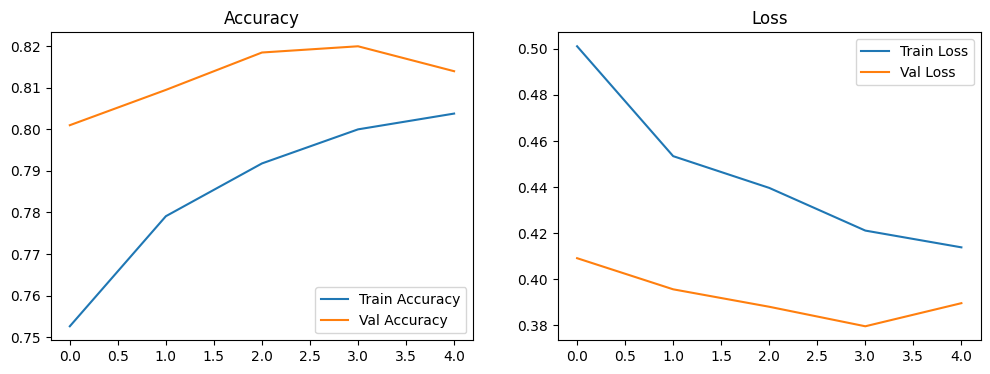

In [6]:
# --------------------------------------------------------
# 🧠 Transfer Learning with Pretrained MobileNetV2 on CIFAR-10
# --------------------------------------------------------

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Load CIFAR-10 dataset (inbuilt)
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
y_train = y_train.flatten()
y_test = y_test.flatten()

# For simplicity, we’ll only use cats (label=3) and dogs (label=5)
train_mask = np.isin(y_train, [3,5])
test_mask = np.isin(y_test, [3,5])

X_train, y_train = X_train[train_mask], y_train[train_mask]
X_test, y_test = X_test[test_mask], y_test[test_mask]

# Convert 3 -> 0 (cat), 5 -> 1 (dog)
y_train = (y_train == 5).astype(int)
y_test = (y_test == 5).astype(int)

# Normalize pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

print("Training samples:", X_train.shape, "Testing samples:", X_test.shape)

# 2️⃣ Load pre-trained MobileNetV2
base_model = keras.applications.MobileNetV2(
    input_shape=(128,128,3),
    include_top=False,
    weights='imagenet'
)

# Freeze pretrained layers
base_model.trainable = False

# 3️⃣ Preprocess CIFAR images to match model input size (128x128)
data_augmentation = keras.Sequential([
    layers.Resizing(128,128),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

# 4️⃣ Build transfer learning model
model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')   # binary: cat vs dog
])

# 5️⃣ Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# 6️⃣ Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=32
)
model.summary()

# 7️⃣ Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# 8️⃣ Plot accuracy/loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')
plt.show()
